In [8]:
# Imports
import pandas as pd
import numpy as np 

import seaborn as sns 
import matplotlib.pylab as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import json
import requests
import yfinance as yf

import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Alpha Vantage API key
api_key = ...

In [9]:
def  plot_dis(y,yhat):
    
    plt.figure()
    ax1 = sns.distplot(y, hist=False, color="r", label="Actual Value")
    sns.distplot(yhat, hist=False, color="b", label="Fitted Values" , ax=ax1)
    plt.legend()

    plt.title('Actual vs Fitted Values')
    plt.xlabel('Price (in dollars)')
    plt.ylabel('Proportion of Prices')

    plt.show()
    plt.close()

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

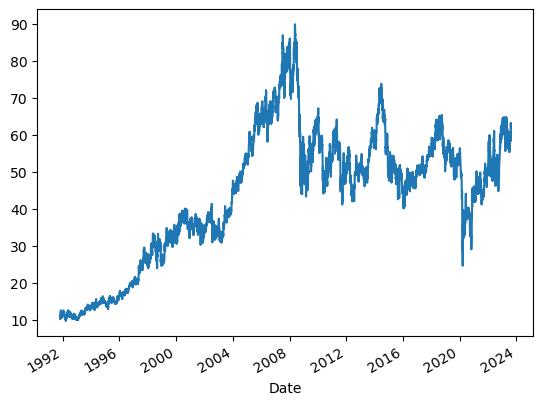

In [28]:
# Let's download TTE stock
stock_data = yf.download('TTE', period="70y")['Close']
stock_data.plot()

In [5]:
# Full data DataFrame
data = pd.DataFrame(columns=['date'])

# Info
infos =  {
    'WTI': 'daily',
    'BRENT': 'daily',
    'NATURAL_GAS': 'daily',
    'COPPER': 'monthly',
    'ALUMINUM': 'monthly',
    'REAL_GDP': 'quarterly',
    'INFLATION': '',
    'RETAIL_SALES': ''
}

# Download and merge
for key, item in infos.items():
    freq = f'&interval={item}' if item != '' else f''
    url = f'https://www.alphavantage.co/query?function={key}{freq}&apikey={api_key}'
    r = requests.get(url, verify=False)
    try:
        temp_data = pd.DataFrame(r.json()['data']).copy()
        temp_data.columns = ['date', key]
        data = pd.merge(data, temp_data, on='date', how='outer')
    except:
        print(key)
        print(r.json())
    
data

REAL_GDP
{'Note': 'Thank you for using Alpha Vantage! Our standard API call frequency is 5 calls per minute and 100 calls per day. Please visit https://www.alphavantage.co/premium/ if you would like to target a higher API call frequency.'}
INFLATION
{'Note': 'Thank you for using Alpha Vantage! Our standard API call frequency is 5 calls per minute and 100 calls per day. Please visit https://www.alphavantage.co/premium/ if you would like to target a higher API call frequency.'}
RETAIL_SALES
{'Note': 'Thank you for using Alpha Vantage! Our standard API call frequency is 5 calls per minute and 100 calls per day. Please visit https://www.alphavantage.co/premium/ if you would like to target a higher API call frequency.'}


date    WTI  BRENT NATURAL_GAS COPPER ALUMINUM
0      2023-08-07  81.94  86.47        2.65    NaN      NaN
1      2023-08-04  82.76  87.38        2.53    NaN      NaN
2      2023-08-03  81.56  86.19        2.44    NaN      NaN
3      2023-08-02   79.5  84.01        2.43    NaN      NaN
4      2023-08-01  81.37  85.34        2.49    NaN      NaN
...           ...    ...    ...         ...    ...      ...
10009  1980-05-01    NaN    NaN         NaN      .        .
10010  1980-04-01    NaN    NaN         NaN      .        .
10011  1980-03-01    NaN    NaN         NaN      .        .
10012  1980-02-01    NaN    NaN         NaN      .        .
10013  1980-01-01    NaN    NaN         NaN      .        .

[10014 rows x 6 columns]

In [32]:
# Let's download our commodities
with open('copper_prices.json') as f:
    copper = pd.DataFrame(json.load(f)['data'])
    copper.columns = ['date', 'copper']

with open('aluminium_prices.json') as f:
    aluminium = pd.DataFrame(json.load(f)['data'])
    aluminium.columns = ['date', 'aluminium']
    
with open('crude_oil_prices_wti.json') as f:
    oil = pd.DataFrame(json.load(f)['data'])
    oil.columns = ['date', 'oil']
    
with open('natural_gas_spot_prices.json') as f:
    gas = pd.DataFrame(json.load(f)['data'])
    gas.columns = ['date', 'gas']
    
with open('gdp.json') as f:
    gdp = pd.DataFrame(json.load(f)['data'])
    gdp.columns = ['date', 'gdp']
    
with open('inflation.json') as f:
    inflation = pd.DataFrame(json.load(f)['data'])
    inflation.columns = ['date', 'inflation']
    
with open('retail_sales.json') as f:
    retail = pd.DataFrame(json.load(f)['data'])
    retail.columns = ['date', 'retail']

In [33]:
data = copper.copy()
data = pd.merge(data, aluminium, on='date', how='outer')
data = pd.merge(data, oil, on='date', how='outer')
data = pd.merge(data, gas, on='date', how='outer')
data = pd.merge(data, gdp, on='date', how='outer')
data = pd.merge(data, inflation, on='date', how='outer')
data = pd.merge(data, retail, on='date', how='outer')
data = data.set_index('date')

In [34]:
data

copper         aluminium    oil   gas       gdp  \
date                                                                    
2023-06-01  8396.51772727273  2184.75363636364  70.09  1.77       NaN   
2023-05-01  8243.15608695652  2274.01260869565  75.65  2.24       NaN   
2023-04-01         8809.1575          2338.131    NaN   NaN  5120.513   
2023-03-01  8856.31086956522  2296.41695652174  77.57  2.59       NaN   
2023-02-01          8936.587         2416.1815  76.34  2.65       NaN   
...                      ...               ...    ...   ...       ...   
1964-01-01               NaN               NaN    NaN   NaN       NaN   
1963-01-01               NaN               NaN    NaN   NaN       NaN   
1962-01-01               NaN               NaN    NaN   NaN       NaN   
1961-01-01               NaN               NaN    NaN   NaN       NaN   
1960-01-01               NaN               NaN    NaN   NaN       NaN   

                   inflation    retail  
date                                    
2023-06-01               NaN  613207.0  
2023-05-01               NaN  631059.0  
2023-04-01               NaN  588220.0  
2023-03-01               NaN  604084.0  
2023-02-01               NaN    529374  
...                      ...       ...  
1964-01-01  1.27891156462583       NaN  
1963-01-01   1.2396694214876       NaN  
1962-01-01  1.19877334820185       NaN  
1961-01-01  1.07072414764723       NaN  
1960-01-01  1.45797598627786       NaN  

[10034 rows x 7 columns]

In [35]:
# EDA + Cleaning

data = data.replace('.', np.nan)  # Create proper nan

stock_data = pd.DataFrame(stock_data)
stock_data.index = pd.to_datetime(stock_data.index)  
stock_data = stock_data.reset_index()
stock_data.columns = ['date', 'close']  # Create dataframe with stock price and datetime index to allow merging

data.index = pd.to_datetime(data.index)
data = data.reset_index()  # Also create date column and turn it into datetime to merge

data = pd.merge(data, stock_data, on='date', how='outer')  # Merging our future X (indicators) and y (stock price)

# Fill NaN, Order by date, Set index with date, Cut DataFrame to keep recent years and turn string numbers into float
data = data.set_index('date').sort_values(by='date', ascending=True).fillna(method='ffill').iloc[-5200:].astype(float).copy()

In [37]:
data = data.sort_values(by='date', ascending=True).fillna(method='ffill').iloc[-5200:].astype(float).copy()
data

copper    aluminium    oil   gas       gdp  inflation  \
date                                                                     
2003-12-16  2202.035714  1557.778571  32.94  6.58  3597.364   2.270095   
2003-12-17  2202.035714  1557.778571  33.36  6.56  3597.364   2.270095   
2003-12-18  2202.035714  1557.778571  33.72  6.98  3597.364   2.270095   
2003-12-19  2202.035714  1557.778571  32.81  6.92  3597.364   2.270095   
2003-12-22  2202.035714  1557.778571  31.71  6.32  3597.364   2.270095   
...                 ...          ...    ...   ...       ...        ...   
2023-08-08  8396.517727  2184.753636  81.94  2.77  5120.513   8.002800   
2023-08-09  8396.517727  2184.753636  81.94  2.77  5120.513   8.002800   
2023-08-10  8396.517727  2184.753636  81.94  2.77  5120.513   8.002800   
2023-08-11  8396.517727  2184.753636  81.94  2.77  5120.513   8.002800   
2023-08-14  8396.517727  2184.753636  81.94  2.77  5120.513   8.002800   

              retail      close  
date                             
2003-12-16  327693.0  43.985001  
2003-12-17  327693.0  44.465000  
2003-12-18  327693.0  45.419998  
2003-12-19  327693.0  44.724998  
2003-12-22  327693.0  44.930000  
...              ...        ...  
2023-08-08  613207.0  60.849998  
2023-08-09  613207.0  62.540001  
2023-08-10  613207.0  63.320000  
2023-08-11  613207.0  62.570000  
2023-08-14  613207.0  61.730000  

[5200 rows x 8 columns]

In [38]:
data['retail'] = data['retail'].rolling(100).mean().fillna(method='backfill')
data['gdp'] = data['gdp'].rolling(100).mean().fillna(method='backfill')

<Axes: xlabel='date'>

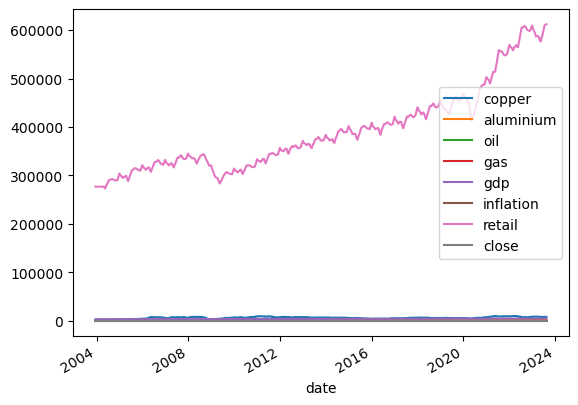

In [39]:
data.plot()

In [40]:
data.describe()

copper    aluminium          oil          gas          gdp  \
count   5200.000000  5200.000000  5200.000000  5200.000000  5200.000000   
mean    6604.311050  2079.431371    69.749252     4.500392  4237.963990   
std     1824.674713   415.624137    22.723554     2.341642   433.448066   
min     2202.035714  1338.062500   -36.980000     1.330000  3515.667520   
25%     5660.350000  1771.380000    51.617500     2.800000  3882.335715   
50%     6821.142857  1990.431818    67.075000     3.800000  4133.457085   
75%     7896.909091  2380.975000    88.025000     5.832500  4602.690960   
max    10230.893913  3498.373043   145.310000    23.860000  5115.422210   

         inflation         retail        close  
count  5200.000000    5200.000000  5200.000000  
mean      2.657205  390950.750502    55.568181  
std       1.981531   85984.243356     9.808542  
min      -0.355546  273223.630000    24.760000  
25%       1.464833  323627.162500    49.097499  
50%       2.130110  372792.455000    53.790001  
75%       3.225944  433382.167500    61.012499  
max       8.002800  611792.000000    89.940002

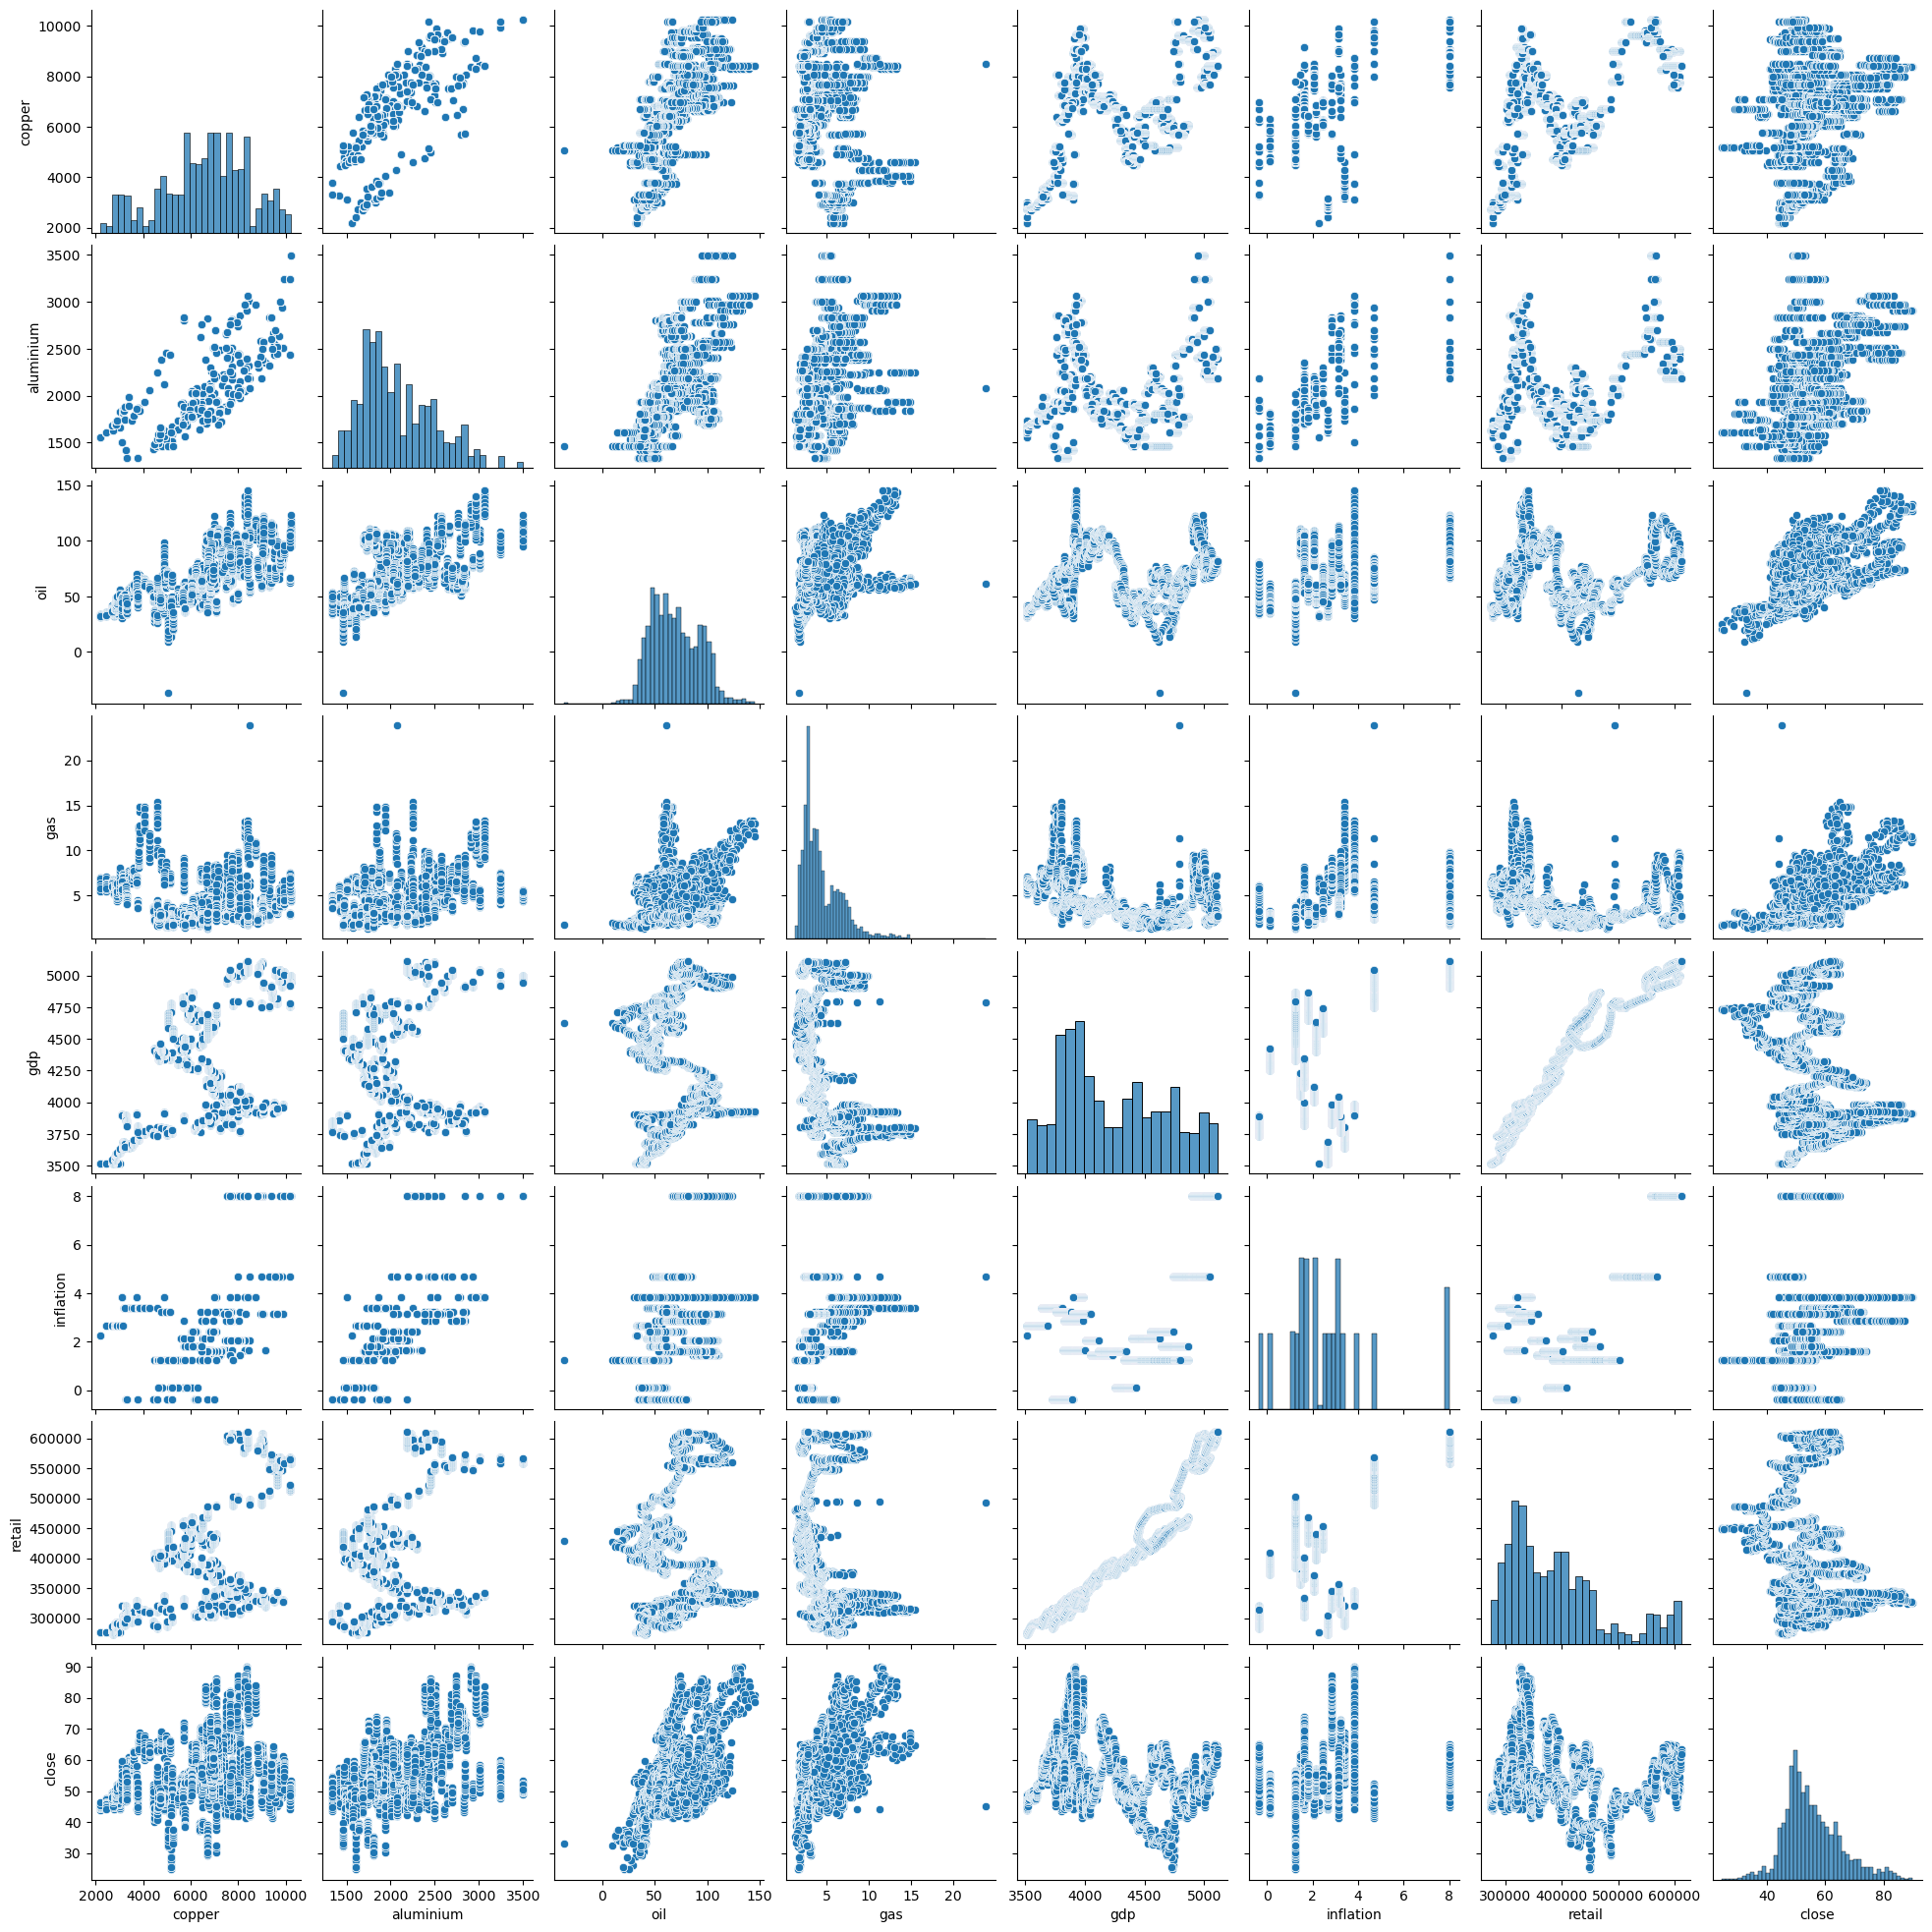

In [41]:
sns.pairplot(data)
plt.show()

<Axes: >

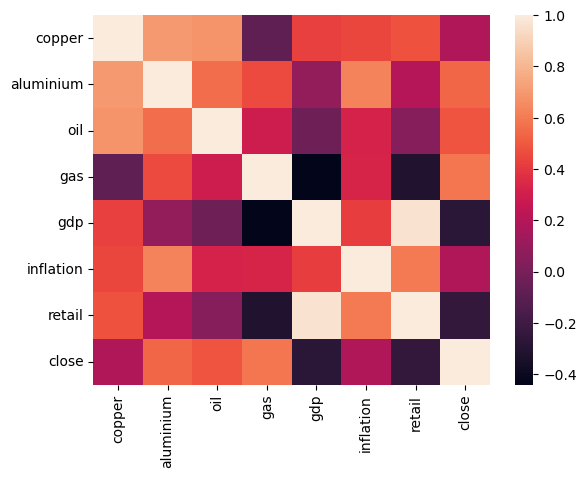

In [42]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix)

In [46]:
# X and y data
X = data.drop('close', axis=1)
y = data['close'].copy()

# Let's create our pipeline
Input = [
    ('scaler', StandardScaler()),
    ('polynomial', PolynomialFeatures(include_bias=False, degree=2)),
    ('model', LinearRegression())
]
pipe = Pipeline(Input) 

# And the different hyper_parameters we can play with here
param_grid = {
    'polynomial__degree': np.arange(1, 5, 1)
}

# Let's define our searching model
search = GridSearchCV(pipe, param_grid, n_jobs=1)

# And split between our train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=False)

# We fit our pipeline and then our model
pipe.fit(X_train, y_train)
search.fit(X_test, y_test)

# And now we can see the best parameter
best=search.best_estimator_
print(best)

# As well as the score of the prediction
print(best.score(X_test,y_test))

Pipeline(steps=[('scaler', StandardScaler()),
                ('polynomial', PolynomialFeatures(include_bias=False)),
                ('model', LinearRegression())])
0.9434581215787398


C:\Users\lzc58\AppData\Local\Temp\ipykernel_13988\2692440140.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(y, hist=False, color="r", label="Actual Value")
C:\Users\lzc58\AppData\Local\Temp\ipykernel_13988\2692440140.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplo

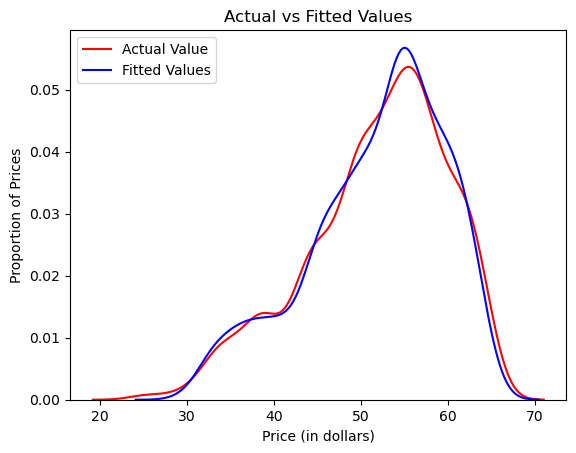

In [47]:
predicted=best.predict(X_test)
plot_dis(y_test,predicted)

<Axes: xlabel='date'>

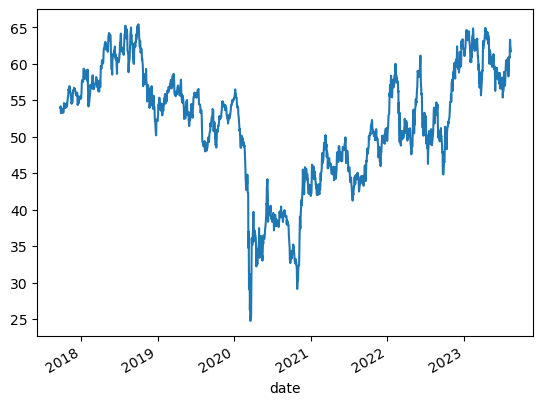

In [48]:
pd.Series(y_test).plot()

<Axes: xlabel='date'>

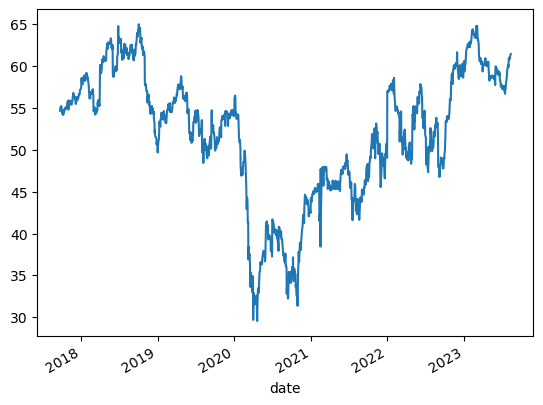

In [49]:
pd.Series(predicted, index=pd.Series(y_test).index).plot()

In [50]:
# SHIFT

shift_data = data.copy()
shift_data['close'] = shift_data['close'].shift(-10)
shift_data = shift_data.dropna()
shift_data

copper    aluminium    oil   gas         gdp  inflation  \
date                                                                       
2003-12-16  2202.035714  1557.778571  32.94  6.58  3518.28940   2.270095   
2003-12-17  2202.035714  1557.778571  33.36  6.56  3518.28940   2.270095   
2003-12-18  2202.035714  1557.778571  33.72  6.98  3518.28940   2.270095   
2003-12-19  2202.035714  1557.778571  32.81  6.92  3518.28940   2.270095   
2003-12-22  2202.035714  1557.778571  31.71  6.32  3518.28940   2.270095   
...                 ...          ...    ...   ...         ...        ...   
2023-07-25  8396.517727  2184.753636  79.76  2.66  5091.66519   8.002800   
2023-07-26  8396.517727  2184.753636  79.11  2.60  5093.36212   8.002800   
2023-07-27  8396.517727  2184.753636  80.17  2.47  5095.05905   8.002800   
2023-07-28  8396.517727  2184.753636  80.55  2.53  5096.75598   8.002800   
2023-07-31  8396.517727  2184.753636  81.80  2.58  5098.45291   8.002800   

               retail      close  
date                              
2003-12-16  276996.43  45.500000  
2003-12-17  276996.43  46.255001  
2003-12-18  276996.43  46.255001  
2003-12-19  276996.43  46.625000  
2003-12-22  276996.43  47.730000  
...               ...        ...  
2023-07-25  610514.78  60.849998  
2023-07-26  610606.01  62.540001  
2023-07-27  610697.24  63.320000  
2023-07-28  610788.47  62.570000  
2023-07-31  610879.70  61.730000  

[5190 rows x 8 columns]

In [51]:
Input = [
    ('scaler', StandardScaler()),
    ('polynomial', PolynomialFeatures(include_bias=False, degree=2)),
    ('model', LinearRegression())
]
pipe = Pipeline(Input)

In [52]:
param_grid = {
    'polynomial__degree': np.arange(1, 5, 1)
}

In [53]:
search = GridSearchCV(pipe, param_grid, n_jobs=1)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=False)

In [55]:
pipe.fit(X_train, y_train)
search.fit(X_test, y_test)
best=search.best_estimator_
best.score(X_test,y_test)

0.9434581215787398

In [56]:
predicted=best.predict(X_test)

C:\Users\lzc58\AppData\Local\Temp\ipykernel_13988\2692440140.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(y, hist=False, color="r", label="Actual Value")
C:\Users\lzc58\AppData\Local\Temp\ipykernel_13988\2692440140.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplo

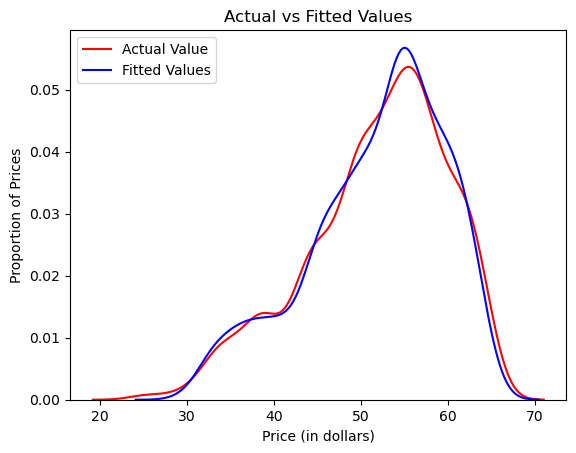

In [57]:
plot_dis(y_test,predicted)

<Axes: xlabel='date'>

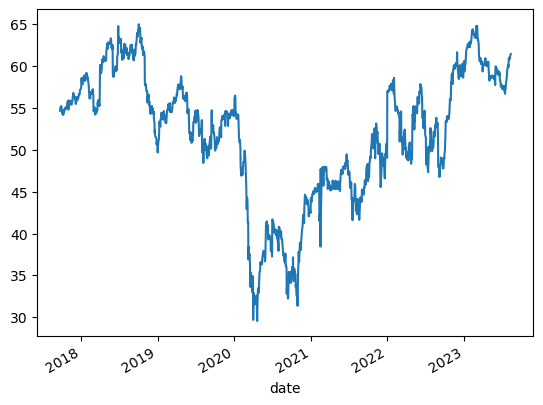

In [58]:
pd.Series(predicted, index=pd.Series(y_test).index).plot()

<Axes: xlabel='date'>

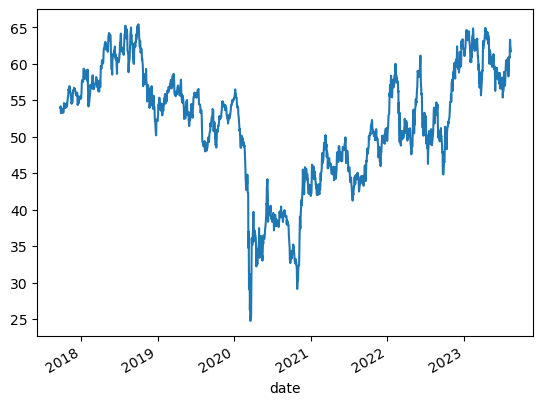

In [59]:
pd.Series(y_test).plot()

In [77]:
# Moving average test
ma1_test = pd.Series(y_test).rolling(8).mean()
ma2_test = pd.Series(y_test).rolling(20).mean()

# Moving average prediction
ma1_pred = pd.Series(predicted, index=pd.Series(y_test).index).rolling(8).mean()
ma2_pred = pd.Series(predicted, index=pd.Series(y_test).index).rolling(20).mean()

<Axes: xlabel='date'>

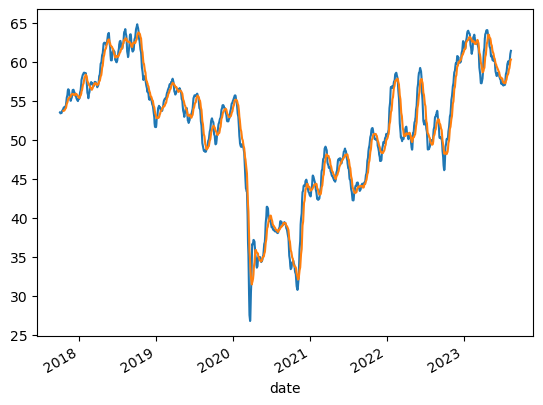

In [78]:
ma1_test.plot()
ma2_test.plot()

In [60]:
import plotly.graph_objects as go


x = pd.Series(y_test).index
fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=y_test,
                    mode='lines',
                    name='test'))

fig.add_trace(go.Scatter(x=x, y=pd.Series(predicted, index=pd.Series(y_test).index),
                    mode='lines',
                    name='prediction'))

fig.show()